## With DQN replay memory (SGD optimizer)

In [27]:
import gym
import roboschool
from environment import Environment
from agent import Agent
from trainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

In [28]:
ENV_NAME = 'BipedalWalker-v2' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #
env = gym.make(ENV_NAME)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


**PLUS KL!!**

``loss_Q_var = torch.sum(0.5 * self.agent.PREC *  torch.pow(Q_var_pred_tf - sum_future_rewards_tf, 2) 
                       + 0.5 / self.agent.BETA * torch.pow(Q_var_pred_tf + loss_KL_tf_list.view((current_batch_size, 1) - Q_var_pred_tf.detach())
                                                  )``

**LAMBDA = 1 !!**

In [29]:
GAMMA=0.99 ######## !!!!!!!! ########
OBS_LEAK = 1e-3 #1e-6 #1e-3
Q_VAR_MULT = 1
augmentation = True
do_reward = True
final = False # True ######## !!!!!!!! ########
HIST_HORIZON = 200 * int(1/OBS_LEAK)
N_PART = 300
N_HIDDEN = 50
optim = 'Adam'
data_path = '200723-Ant-final-with-reward-DQN-G1.npy'
BETA_range = [20] #[5,10,15,20,25,30,35,40,45,50]
PREC_range = [20] #[1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3]
ALPHA = 1e-3 / Q_VAR_MULT / PREC_range[0] #1e-5


In [30]:
HIST_HORIZON

200000

In [31]:
N = 10

In [32]:
offPolicy = False
monte_carlo=True
isTime=False

In [33]:
import time
import os

mem_rtg = []
mem_max_rtg = []


if not os.path.isfile(data_path):
    mem_obs_final = {}
    mem_total_reward = {}

    tic = time.clock()
    for BETA in BETA_range:
        mem_obs_final[BETA] = {}
        mem_total_reward[BETA] = {}

        for PREC in PREC_range:
            print("BETA=", BETA, ", PREC=", PREC)
            toc = time.clock()
            print("Elapsed time:", toc - tic)

            agent = Agent(env,
                  ALPHA=ALPHA,
                  GAMMA=GAMMA, 
                  BETA=BETA, 
                  PREC=PREC,
                  do_reward=do_reward,
                  Q_VAR_MULT=Q_VAR_MULT,
                  isTime=isTime,    #!! TimeAgent
                  offPolicy=offPolicy,
                  HIST_HORIZON = HIST_HORIZON,
                  optim=optim,
                  N_HIDDEN=N_HIDDEN) 
            trainer = Final_variational_trainer(agent, 
                                            monte_carlo=monte_carlo, 
                                            augmentation=augmentation,
                                            final=final,
                                            OBS_LEAK=OBS_LEAK,
                                            ref_prob='unif',
                                            N_PART=N_PART,
                                            KNN_prob=True)
            for i in range(N):
                trainer.run_episode()
                #final_time = agent.get_time()
                #liste_rtg = np.zeros(final_time)
                #for time in range(final_time):
                #    liste_rtg[time] = np.sum(np.array(trainer.reward_history[time:]) * \
                #               agent.GAMMA **(np.arange(time, final_time) - time))
                #mem_rtg.append(np.mean(liste_rtg))    
                #mem_max_rtg.append(np.max(liste_rtg))    
                if (i+1)%10 ==0:
                    #plt.figure(figsize = (4, 4))
                    #plt.plot(agent.KL.flatten())
                    print(trainer.nb_trials)
                    #print("Trajectory: ", trainer.trajectory)
                    print("Total reward got: %.4f" % trainer.total_reward)
                    print("#time steps : %d" % len(trainer.trajectory))
                    print('mean rtg:', np.mean(trainer.rtg_history))
                    

            
            mem_obs_final[BETA][PREC] = trainer.mem_obs_final
            mem_total_reward[BETA][PREC] = trainer.mem_total_reward
            
            obs = (0, 0, 0)
            actions_set = trainer.set_actions_set()
            #Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
            
            #pred_var = agent.Q_var(obs, actions_set[0]) #trainer.agent.softmax_expectation(obs, Q_obs)
            #mem_pred_var[trial][BETA][PREC] = pred_var

            #data = np.array((mem_obs_final, mem_total_reward, mem_pred_reward, mem_pred_var))
            #np.save(data_path, data)

    #data = np.array((mem_obs_final, mem_total_reward))
    #np.save(data_path, data)
else:
    data = np.load(data_path)
    mem_obs_final = data[0]
    mem_total_reward = data[1]


        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


BETA= 20 , PREC= 20
Elapsed time: 0.00013799999942420982
10
Total reward got: -111.4888
#time steps : 81
mean rtg: -74.18134534782185


In [ ]:
N=10000
for i in range(N):
        trainer.run_episode()
        #final_time = agent.get_time()
        #liste_rtg = np.zeros(final_time)
        #for time in range(final_time):
        #    liste_rtg[time] = np.sum(np.array(trainer.reward_history[time:]) * \
        #               agent.GAMMA **(np.arange(time, final_time) - time))
        #mem_rtg.append(np.mean(liste_rtg))    
        #mem_max_rtg.append(np.max(liste_rtg))   
        if (i+1)%10 ==0:
            #plt.figure(figsize = (4, 4))
            #plt.plot(agent.KL.flatten())
            print(trainer.nb_trials)
            #print("Trajectory: ", trainer.trajectory)
            print("Total reward got: %.4f" % trainer.total_reward)
            print("#time steps : %d" % len(trainer.trajectory))
            print('mean rtg:', np.mean(trainer.rtg_history))

206
Total reward got: -116.9642
#time steps : 77
mean rtg: -78.3017449375637
216
Total reward got: -103.5786
#time steps : 69
mean rtg: -73.25836452632782
226
Total reward got: -106.0046
#time steps : 92
mean rtg: -67.55450668234832
236
Total reward got: -63.8483
#time steps : 1601
mean rtg: -3.835517137161609
246
Total reward got: -93.6663
#time steps : 1601
mean rtg: -5.357522657769269
256
Total reward got: -97.3633
#time steps : 1601
mean rtg: -5.551024060585758
266
Total reward got: -86.2150
#time steps : 1601
mean rtg: -5.049807526373567
276
Total reward got: -83.3135
#time steps : 1601
mean rtg: -4.876306009371103
286
Total reward got: -83.7625
#time steps : 1601
mean rtg: -4.988430300405423
296
Total reward got: -82.5823
#time steps : 1601
mean rtg: -4.772836544768764
306
Total reward got: -80.7949
#time steps : 1601
mean rtg: -4.531193976787879
316
Total reward got: -64.3288
#time steps : 1601
mean rtg: -3.661896653498104
326
Total reward got: -67.3237
#time steps : 1601
mean r

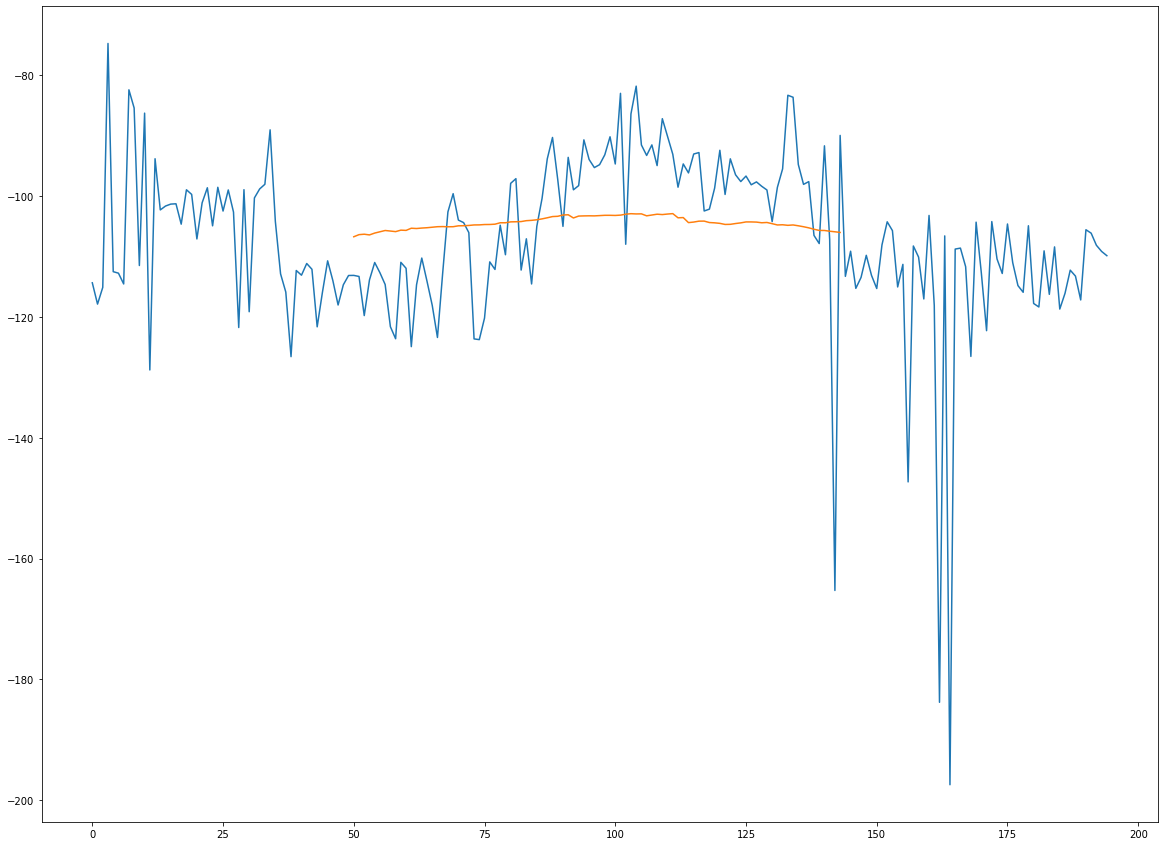

In [51]:
%matplotlib inline
N_eff = len(trainer.mem_total_reward)
plt.figure(figsize=(20,15))
plt.plot(trainer.mem_total_reward)
plt.plot(range(50,N_eff-51), np.convolve( trainer.mem_total_reward,np.ones(100)*1/100)[100:-100], markersize=5)

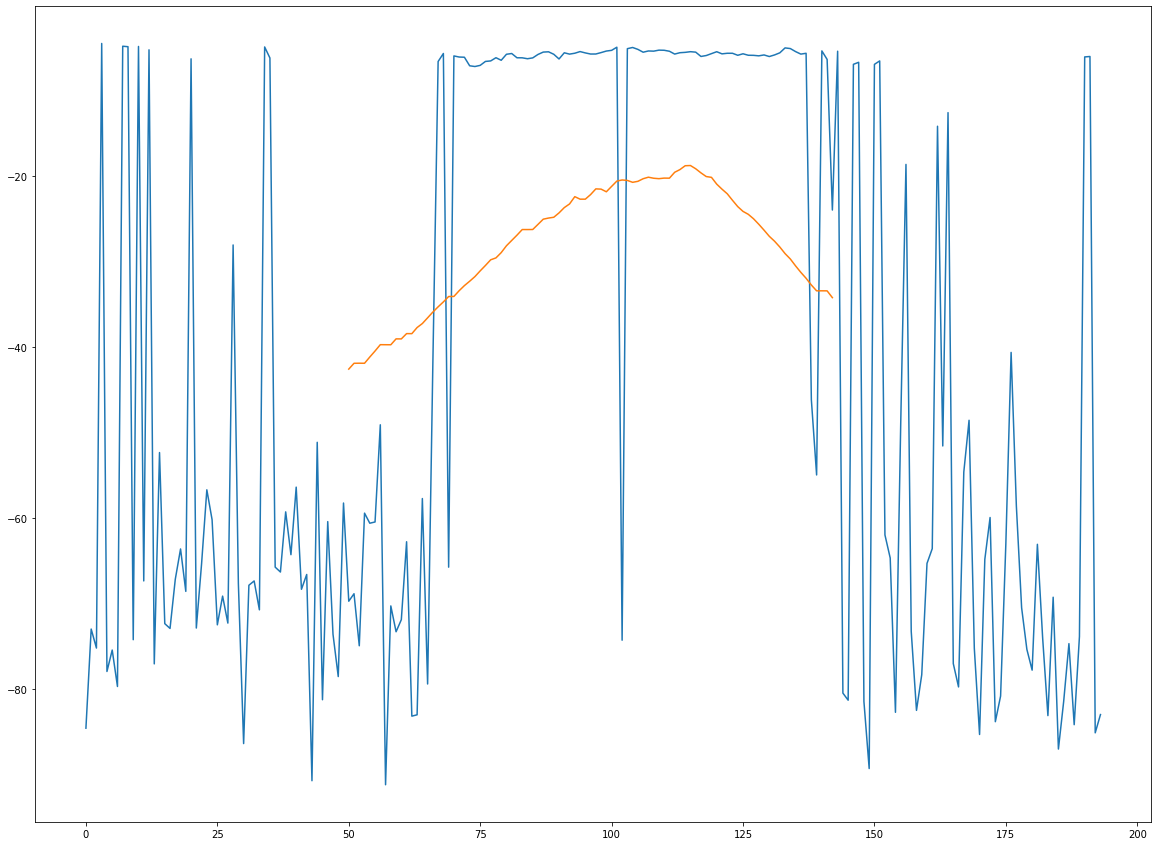

In [35]:
%matplotlib inline
N_eff = len(trainer.mem_mean_rtg)
plt.figure(figsize=(20,15))
plt.plot(trainer.mem_mean_rtg)
plt.plot(range(50,N_eff-51), np.convolve(trainer.mem_mean_rtg,np.ones(100)*1/100)[100:-100], markersize=5)

Text(0.5, 1.0, 'MEAN RTG :-11.038913')

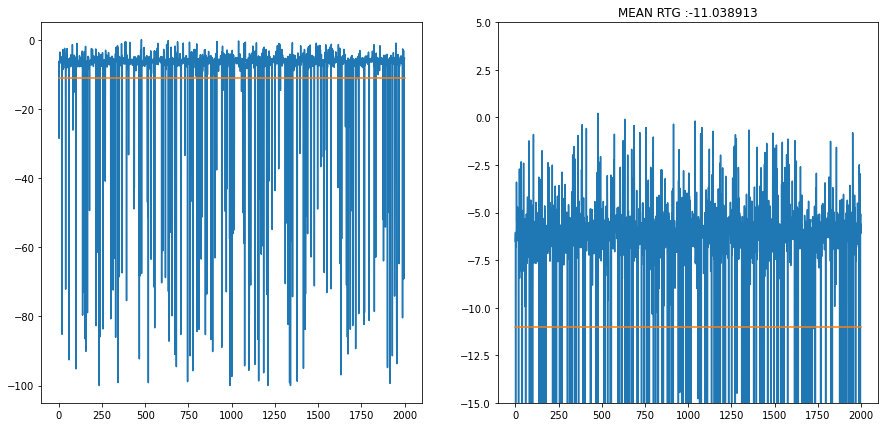

In [36]:
from agent import Transition
transitions = agent.memory.sample(2000)
batch = Transition(*zip(*transitions))
#obs = trainer.agent.get_observation()
sum_future_rewards_batch = np.array(batch.sum_future_rewards)
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
ax1.plot(sum_future_rewards_batch)
m = np.mean(sum_future_rewards_batch)
ax1.plot((1,2000),(m,m))
ax2.plot(sum_future_rewards_batch)
ax2.plot((1,2000),(m,m))
ax2.set_ylim(-15,5)
ax2.set_title('MEAN RTG :' + str(m))


#act_probs = trainer.agent.softmax(obs, actions_set=actions_set)
#act_probs

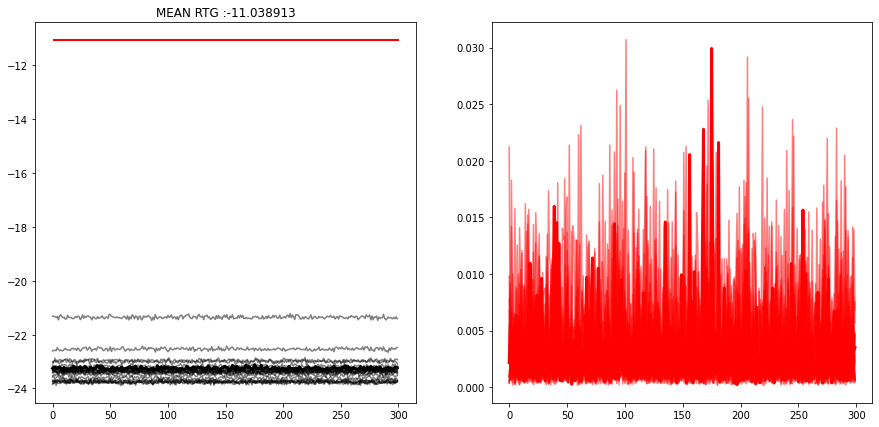

In [37]:
#obs = trainer.agent.get_observation()
transitions = agent.memory.sample(20)
batch = Transition(*zip(*transitions))
obs_batch = np.array(batch.obs)
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in obs_batch:
    actions_set = trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)
    ax1.plot((1,trainer.N_PART), (m,m), 'r')
    ax1.set_title('MEAN RTG :' + str(m))
    ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', alpha=.5)
ax1.plot(Q_obs,'k',linewidth=3)
ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', linewidth=3)

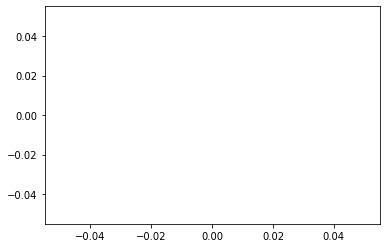

In [38]:
plt.plot(trainer.reward_history)

-109.86096844078787


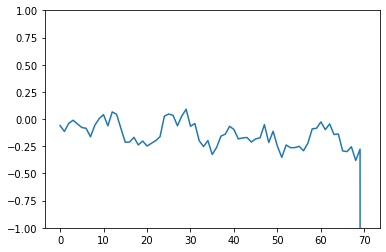

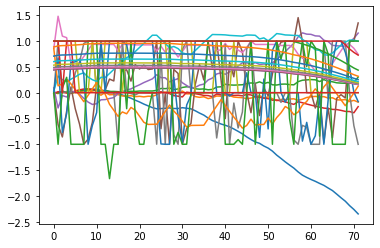

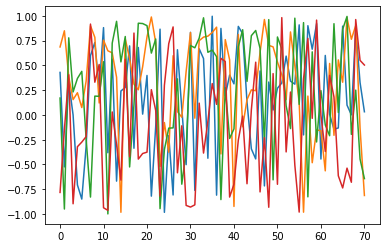

In [39]:
%matplotlib tk
agent.env=env
trainer.run_episode(render=True)
%matplotlib inline
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.figure()
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.figure()
plt.plot(trainer.action_history)


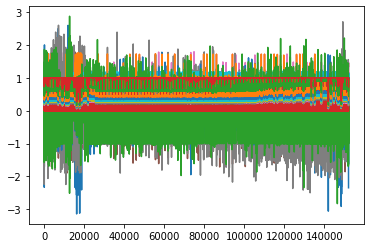

In [40]:
_ = plt.plot(trainer.mem_obs)

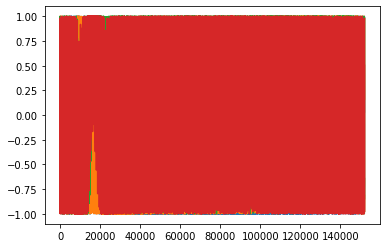

In [41]:
_ = plt.plot(trainer.mem_act)

In [42]:
len(trainer.mem_obs)

152026

OK


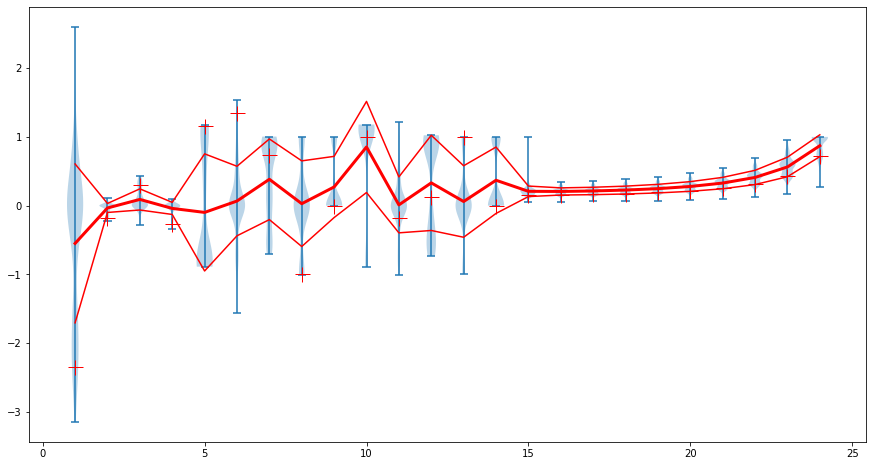

In [43]:
from scipy.stats import multivariate_normal

b_inf = min(trainer.HIST_HORIZON, len(trainer.mem_obs))
mem_obs = trainer.mem_obs
mem_obs_final = np.array(trainer.mem_obs_final)
mu = np.mean(mem_obs[-b_inf:], axis=0)
var = np.var(mem_obs[-b_inf:], axis=0)

print('OK')

plt.figure(figsize=(15,8))
fig = plt.violinplot(mem_obs_final)

b_inf = min(int(1/trainer.OBS_LEAK), len(trainer.mem_obs_final))
mu_final = np.mean(trainer.mem_obs_final[-b_inf:], axis=0)
var_final = np.var(trainer.mem_obs_final[-b_inf:], axis=0)
#rv = multivariate_normal(mu, var)
plt.plot(np.arange(len(mu_final))+1, mu_final, 'r', linewidth=3)
plt.plot(np.arange(len(mu_final))+1,mu_final+np.sqrt(var_final), 'r')
plt.plot(np.arange(len(mu_final))+1,mu_final-np.sqrt(var_final), 'r')

#rv = multivariate_normal(mu_final, var_final)
#for i in range(100):
#    plt.plot(np.arange(len(mu_final))+1, rv.rvs(),'.k', alpha=.1)
    
#rv = multivariate_normal(mu, var)
#for i in range(100):
#    plt.plot(np.arange(len(mu))+1, rv.rvs(),'.r', alpha=.1)
    
obs = trainer.trajectory[-1]
plt.plot(np.arange(len(mu_final))+1, obs,'r+', markersize=15)

OK


Text(0.5, 1.0, 'ACT')

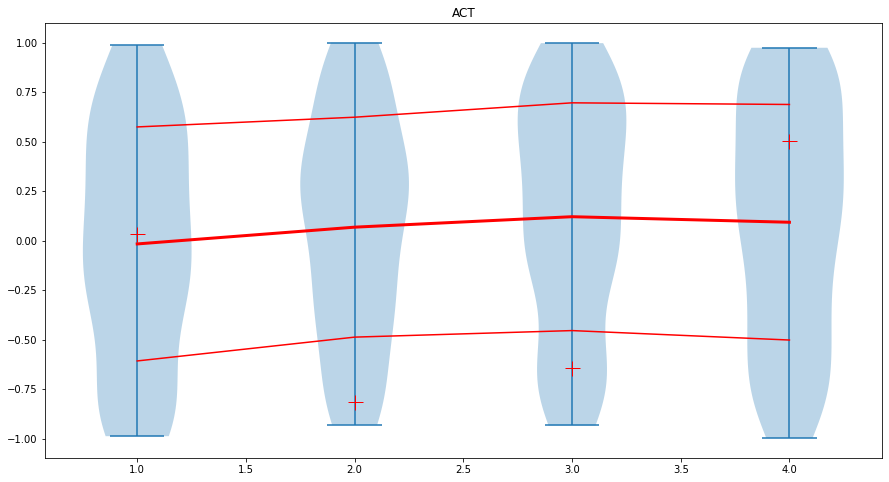

In [44]:
from scipy.stats import multivariate_normal

mem_act = np.array(trainer.mem_act[:100:])

b_inf = min(trainer.HIST_HORIZON, len(mem_act))
#mem_obs_final = np.array(trainer.mem_obs_final)
#mu = np.mean(mem_act[-b_inf:], axis=0)
#var = np.var(mem_act[-b_inf:], axis=0)

print('OK')

plt.figure(figsize=(15,8))
fig = plt.violinplot(mem_act)

b_inf = min(int(200/trainer.OBS_LEAK), len(mem_act))
mu_act = np.mean(mem_act[-b_inf:], axis=0)
var_act = np.var(mem_act[-b_inf:], axis=0)
#rv = multivariate_normal(mu, var)
plt.plot(np.arange(len(mu_act))+1, mu_act, 'r', linewidth=3)
plt.plot(np.arange(len(mu_act))+1,mu_act+np.sqrt(var_act), 'r')
plt.plot(np.arange(len(mu_act))+1,mu_act-np.sqrt(var_act), 'r')

#rv = multivariate_normal(mu_final, var_final)
#for i in range(100):
#    plt.plot(np.arange(len(mu_final))+1, rv.rvs(),'.k', alpha=.1)
    
#rv = multivariate_normal(mu, var)
#for i in range(100):
#    plt.plot(np.arange(len(mu))+1, rv.rvs(),'.r', alpha=.1)
    
act = trainer.action_history[-1]
plt.plot(np.arange(len(mu_act))+1, act,'r+', markersize=15)
plt.title('ACT')

-9.35600017183591
-5.241841858868831
-4.11415831296708


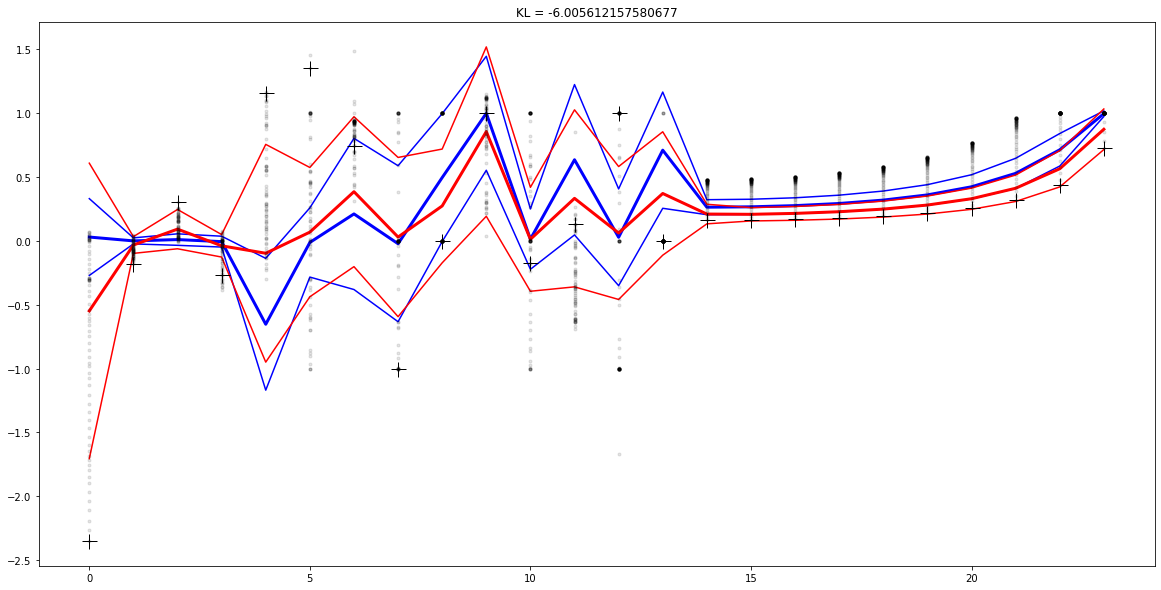

In [45]:
plt.figure(figsize=(20,10))
plt.plot(mu,'b', linewidth=3)
plt.plot(mu+np.sqrt(var),'b')
plt.plot(mu-np.sqrt(var),'b')
plt.plot(mu_final, 'r', linewidth=3)
plt.plot(mu_final+np.sqrt(var_final),'r')
plt.plot(mu_final-np.sqrt(var_final),'r')
plt.plot(obs,'+k', markersize=15)
_ = plt.plot(np.array(trainer.trajectory).T,'k.', alpha=.1)
plt.title('KL = ' + str(trainer.KL(trainer.mem_obs_final[-1], done=True)))
print(np.log(trainer.calc_final_state_probs()(obs)))
print(np.log(trainer.ref_probs))
print(np.log(trainer.calc_final_state_probs()(obs)) - np.log(trainer.ref_probs))

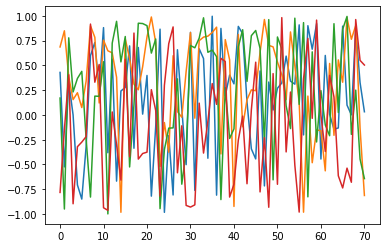

In [46]:
plt.plot(trainer.action_history)

In [47]:
mean_obs = np.zeros((len(BETA_range), len(PREC_range)))
mean_reward = np.zeros((len(BETA_range), len(PREC_range)))

for i, BETA in enumerate(BETA_range):
    for j, PREC in enumerate(PREC_range):
        mean_obs[i,j] = np.mean(mem_obs_final[BETA][PREC])
        mean_reward[i,j] = np.mean(mem_total_reward[BETA][PREC])
    
        

Text(0.5, 1.0, 'Mean final obs')

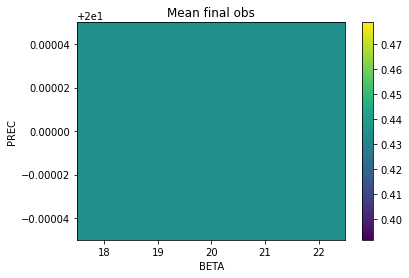

In [48]:
#plt.imshow(mean_obs)
im = plt.imshow(mean_obs.T, 
              origin='lower', 
              extent=[min(BETA_range)-2.5, max(BETA_range)+2.5,
                      min(PREC_range)-5e-5, max(PREC_range)+5e-5],
              aspect = 'auto',
              alpha=1)
plt.colorbar(im)
plt.xlabel('BETA')
plt.ylabel('PREC')
plt.title('Mean final obs')


Text(0.5, 1.0, 'Mean reward')

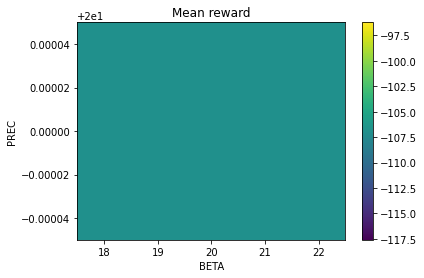

In [49]:
im = plt.imshow(mean_reward.T, 
              origin='lower', 
              extent=[min(BETA_range)-2.5, max(BETA_range)+2.5,
                      min(PREC_range)-5e-5, max(PREC_range)+5e-5],
              aspect = 'auto',
              alpha=1)
plt.colorbar(im)
plt.xlabel('BETA')
plt.ylabel('PREC')
plt.title('Mean reward')

In [50]:


#BETA = 30
#PREC = 0.0009
plt.figure(figsize=(20,15))
plt.plot(np.array(mem_obs_final[BETA][PREC])[:,:])

IndexError: too many indices for array

<Figure size 1440x1080 with 0 Axes>

In [ ]:
plt.figure(figsize = (20,20))
for i, BETA in enumerate(BETA_range):
    for j, PREC in enumerate(PREC_range):
        plt.subplot(10,10,i*10+j+1)
        plt.plot(np.array(mem_obs_final[BETA][PREC])[:,0])
        if i < 9:
            plt.xticks([])
        else:
            plt.xlabel('PREC='+str(PREC))
        plt.ylim([-1.1,0.6])
        if j > 0:
            plt.yticks()
        else:
            plt.ylabel('BETA='+str(BETA))

In [ ]:
obs = agent.get_observation()
obs

In [ ]:
trainer.final

In [ ]:
np.concatenate((obs, agent.one_hot(1)))

In [ ]:
agent.Q_KL(obs,0, tf=True)

In [ ]:
agent.softmax_choice([0, 0, 0, 0])

In [ ]:
m = (agent.env.observation_space.high + agent.env.observation_space.low) / 2
m

In [ ]:
agent.env.observation_space.high

In [ ]:
agent.env.observation_space.low

In [ ]:
from scipy.stats import multivariate_normal
test = np.array(trainer.mem_obs_final).T
mu = np.mean(test, axis = 1)
Sigma = np.cov(np.array(trainer.mem_obs_final).T)
rv = multivariate_normal(mu, Sigma)

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(np.array(trainer.mem_obs_final)[:,:2])

In [ ]:
trainer.action_history

In [ ]:
trainer.agent.softmax(trainer.agent.get_observation())

In [ ]:
obs = (0,0,0) #trainer.agent.get_observation()

In [ ]:
trainer.agent.set_Q_obs(obs, Q = agent.Q_KL)

In [ ]:
trainer.agent.set_Q_obs(obs, Q = agent.Q_var)

In [ ]:
trainer.Q_learning

In [ ]:
agent.N_act

In [ ]:
%matplotlib inline
import time
import seaborn
seaborn.set()
axe = np.arange(-100,100)/100

p_ref = 1 / np.prod(agent.env.observation_space.high - agent.env.observation_space.low)

f={}
KL={}
pred_KL={}
pred_reward={}
pred_var={}
act = {}
for v in [-0.01, 0.0, 0.01]:
    f[v] = np.zeros(200)
    KL[v] = np.zeros(200)
    pred_KL[v] = np.zeros(200)
    pred_reward[v] = np.zeros(200)
    pred_var[v] = np.zeros(200)
    act[v] = []
    for a in range(agent.N_act):
        act[v].append(np.zeros(200))

for i in range(200):
    for v in [-0.01, 0.0, 0.01]:
        obs = (axe[i], v, 0)
        tic_1 = time.clock()
        f[v][i] = rv.pdf(obs)
        tic_2 = time.clock()
        KL[v][i] = np.log(f[v][i]) - np.log(p_ref)
        tic_3 = time.clock()
        #pred_KL[i] = trainer.calc_sum_future_KL(obs, obs, done=False)
        sum_future_KL = trainer.KL(obs, done=False)
        tic_3_1 = time.clock()
        next_values = agent.set_Q_obs(obs, Q=agent.Q_KL)
        tic_3_2 = time.clock()
        next_sum = agent.softmax_expectation(obs, next_values)
        tic_3_3 = time.clock()
        pred_KL[v][i] += agent.GAMMA * next_sum
        
        tic_4 = time.clock()   
        pred_reward[v][i] = trainer.calc_sum_future_rewards(0, obs, done=False)
        tic_5 = time.clock()   
        pred_var[v][i] = trainer.agent.softmax_expectation(obs, trainer.agent.set_Q_obs(obs))
        tic_6 = time.clock()   
        if i ==0:
            print('rv.pdf(obs)',
                 (tic_2-tic_1)*1000)
            print('np.log(f[i]) - np.log(p_ref)',
                  (tic_3-tic_2)*1000)
            print('trainer.calc_sum_future_KL(obs, obs, done=False)',
                  (tic_4-tic_3)*1000)
            print('sum_future_KL = trainer.KL(obs, done=False)',
                  (tic_3_1-tic_3)*1000)
            print('next_values = agent.set_Q_obs(obs, Q=agent.Q_KL)',
                  (tic_3_2-tic_3_1)*1000)
            print('next_sum = agent.softmax_expectation(obs, next_values)',
                  (tic_3_3-tic_3_2)*1000)
            print('trainer.calc_sum_future_rewards(0, obs, done=False)',
                  (tic_5-tic_4)*1000)
            print('trainer.agent.softmax_expectation(obs, trainer.agent.set_Q_obs(obs))',
                  (tic_6-tic_5)*1000)
        for a in range(agent.N_act):
            act[v][a][i] = trainer.agent.Q_var(obs,a)
       
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, f[v], label=v)
plt.plot((-1, 1), (p_ref, p_ref))
plt.plot([-0.5, -0.5],[0, 400],'r--')
plt.legend()
#plt.title()
plt.figure()
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, KL[v], label='instant KL ('+str(v)+')')
plt.plot((-1, 1), (0, 0))
plt.plot([-0.5, -0.5],[-400, 400],'r--')
plt.ylim((-10,10))
plt.legend()
plt.figure()
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, pred_KL[v], label='sum future KL ('+str(v)+')')
plt.plot([-0.5, -0.5],[-400, 400],'r--')
plt.ylim((-10,10))
#plt.ylim([-1, 5])
plt.legend()
plt.figure()
for v in [-0.01, 0.0, 0.01]:
    plt.plot(axe, pred_reward[v], label='sum future rewards ('+str(v)+')')
    plt.plot(axe, pred_var[v], label='softmax value ('+str(v)+')')
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.legend()
plt.figure()
for a in range(agent.N_act):
    plt.plot(axe, act[-0.01][a], label='act '+str(a))
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.title(-0.01)
plt.legend()
plt.figure()
for a in range(agent.N_act):
    plt.plot(axe, act[0.][a], label='act '+str(a))
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.title(0.0)
plt.legend()
plt.figure()
for a in range(agent.N_act):
    plt.plot(axe, act[0.01][a], label='act '+str(a))
plt.plot([-0.5, -0.5],[-1, 1],'r--')
plt.title(0.01)
plt.legend()

In [ ]:
%matplotlib inline
plt.plot(trainer.mem_total_reward)

In [ ]:
%matplotlib tk
agent.env=env
trainer.run_episode(render=True)
plt.plot(trainer.trajectory)
print(trainer.total_reward)

In [ ]:
trainer.action_history

In [ ]:
%matplotlib inline
data_obs = np.array(trainer.mem_obs)
r = len(trainer.mem_obs) // 20
plt.figure(figsize=(20,15))
for inter in range(20):
    b_min = r *inter
    b_max = b_min + r
    mu = np.mean(data_obs[b_min:b_max,:].T, axis = 1)
    Sigma = np.cov(data_obs[b_min:b_max,:].T)
    rv = multivariate_normal(mu, Sigma)
    axe_0 = np.linspace(-1.3, 0.5, 101)
    axe_1 = np.linspace(-0.1, 0.1, 101)
    proba = np.zeros((101, 101))
    for i, x in enumerate(axe_0):
        for j, y in enumerate(axe_1):
            obs = (x, y, 0, 0)
            proba[i,j] = rv.pdf(obs)
    ax = plt.subplot(5,4,inter+1)
    ax.imshow(proba.T, 
              origin='lower', 
              extent=[-1.3,
                       0.5, 
                       -0.1,
                       0.1],
              aspect = 'auto')
    #plt.colorbar()
    #ax = plt.subplot(5,4,inter+2)
    ax.plot(data_obs[b_min:b_max,0], data_obs[b_min:b_max,1], '.r', markersize= 1, alpha = .1)
    plt.xlim((-1.3,0.5))
    plt.ylim((-0.1,0.1))
    

In [ ]:
np.array(1).ndim

In [ ]:
int(1/0.1)

In [ ]:
np.mean(trainer.mem_obs[-1000:], axis = 0)